In [76]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.ensemble.partial_dependence import plot_partial_dependence


%matplotlib inline

In [53]:
df = pd.read_csv("data/churn_train.csv")
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,6.94,5.0,5.0,1.00,Astapor,2014-05-03,Android,2014-01-12,0.0,0,False,100.0
1,8.06,5.0,5.0,1.00,Astapor,2014-01-26,Android,2014-01-25,0.0,2,True,0.0
2,21.50,4.0,NaN,1.00,Winterfell,2014-05-21,iPhone,2014-01-02,0.0,1,True,100.0
3,9.46,5.0,NaN,2.75,Winterfell,2014-01-10,Android,2014-01-09,100.0,1,False,100.0
4,13.77,5.0,NaN,1.00,Winterfell,2014-05-13,iPhone,2014-01-31,0.0,0,False,100.0


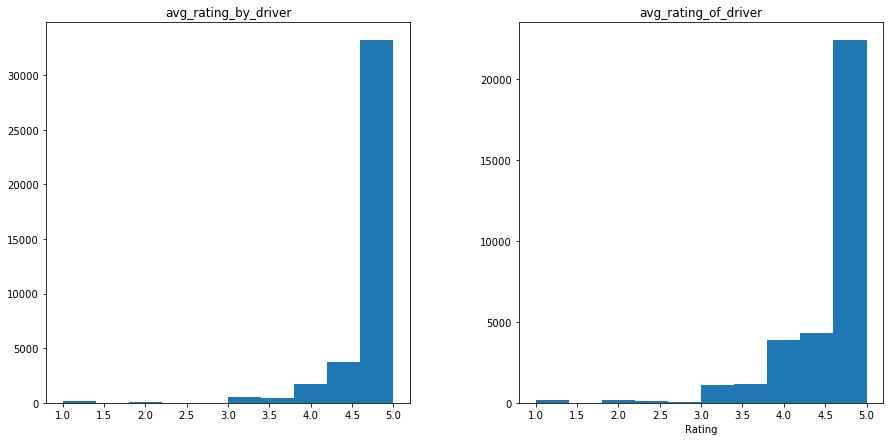

In [74]:
df.hist(['avg_rating_by_driver','avg_rating_of_driver'],grid=False,figsize=(15,7))
plt.xlabel('Rating')

plt.savefig('rating_histogram.jpg')
plt.show()

In [55]:
def clean(df):
    df['churn'] =1 * (df.last_trip_date >= '2014-06-01')
    df.phone = pd.get_dummies(df.phone) # Android: 1, IPhone: 0
    df.rename(index = str, columns = {'phone': 'Android'}, inplace=True)# change the name

    df = pd.concat([df, pd.get_dummies(df.city, drop_first=True)], axis=1)
    df.drop('city', inplace=True, axis = 1)
    
    pull_date = pd.to_datetime('2014-07-01')
    df['acc_age'] = (pull_date - pd.to_datetime(df['signup_date']) ) / np.timedelta64(1,'D')
    df.drop(['signup_date','last_trip_date'], inplace=True, axis = 1)
    
    # Dummy luxury car
    df['luxury_car_user'] = 1 * (df['luxury_car_user'])
    # Thresholds
    rat_by_t = df['avg_rating_by_driver'].median(axis=0)
    rat_of_t = df['avg_rating_of_driver'].median(axis=0)
    
    df['Rate_by_High'] = 1 * (df['avg_rating_by_driver'] >= rat_by_t)
    df['Rate_by_Low'] = 1 * (df['avg_rating_by_driver'] < rat_by_t)
    df['Rate_of_High'] = 1 * (df['avg_rating_of_driver'] >= rat_of_t)
    df['Rate_of_Low'] = 1 * (df['avg_rating_of_driver'] < rat_of_t)
    df.drop(['avg_rating_by_driver','avg_rating_of_driver'], inplace=True, axis = 1)
    return df

churn = clean(df)
y = churn.churn
X = churn.drop(['churn'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1)

In [166]:
churn.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,Android,surge_pct,trips_in_first_30_days,weekday_pct,churn,King's Landing,Winterfell
count,33367.000000,33367.000000,33367.000000,33367.000000,33367.000000,33367.000000,33367.000000,33367.000000,33367.000000,33367.000000,33367.000000
mean,5.466273,4.776168,4.601987,1.073655,0.290527,8.861330,2.615728,61.268909,0.410286,0.212455,0.461024
std,5.144551,0.404764,0.613463,0.197742,0.454012,18.309946,4.082060,34.813958,0.491893,0.409051,0.498486
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,0.000000,37.500000,0.000000,0.000000,0.000000
50%,3.790000,5.000000,4.900000,1.000000,0.000000,0.000000,1.000000,66.700000,0.000000,0.000000,0.000000
75%,6.480000,5.000000,5.000000,1.070000,1.000000,11.100000,3.000000,100.000000,1.000000,0.000000,1.000000
max,79.690000,5.000000,5.000000,8.000000,1.000000,100.000000,125.000000,100.000000,1.000000,1.000000,1.000000


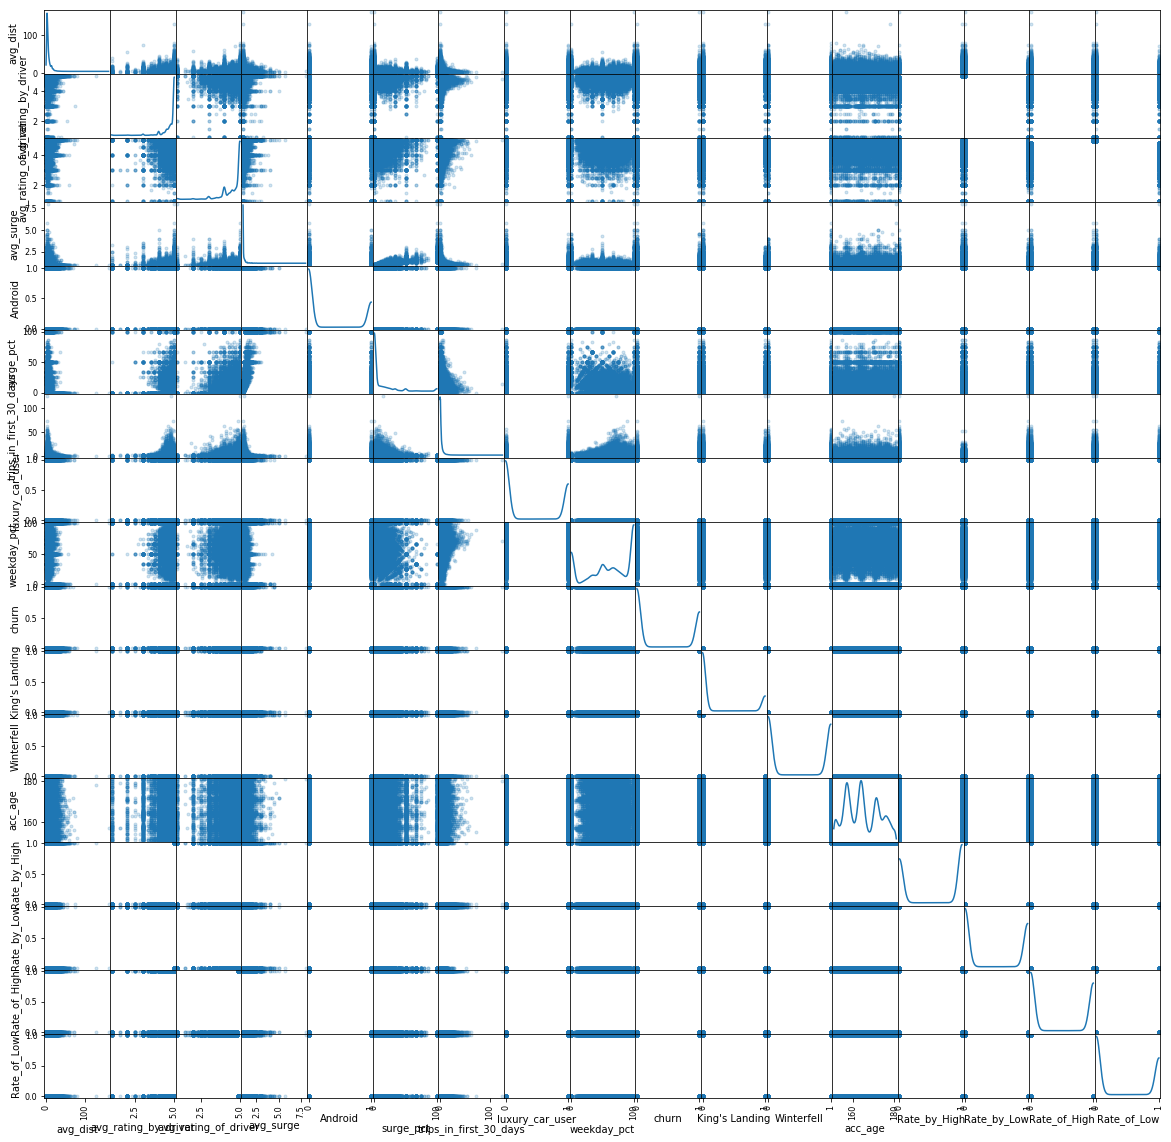

In [40]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(churn, alpha=0.2, figsize=(20, 20), diagonal='kde')
plt.show()

In [66]:
def printscores(model,y_final, y_final_pred):
    print 'Model:', model.__class__.__name__
    print 'training accuarcy score:',model.score(X_train, y_train)
    print 'final test accuracy score: ',model.score(X_final, y_final)
    print 'final test precision score:', metrics.precision_score(y_final,y_final_pred)
    print 'final test recall score:', metrics.recall_score(y_final,y_final_pred)
    print metrics.confusion_matrix(y_final,y_final_pred)

In [56]:
testdf = pd.read_csv('data/churn_test.csv')
testdf = clean(testdf)
y_final = testdf.churn
X_final = testdf.drop(['churn'], axis = 1)

In [67]:
#Logistic Regression
logreg = LogisticRegression().fit(X_train, y_train)
logpred = logreg.predict(X_final)
printscores(logreg, y_final,logpred)


Model: LogisticRegression
training accuarcy score: 0.746366666667
final test accuracy score:  0.7415
final test precision score: 0.682784108408
final test recall score: 0.587751855779
[[5198 1030]
 [1555 2217]]


In [68]:
#Random Forest
rf = RandomForestClassifier(n_estimators=50,n_jobs=-1,oob_score=True,max_depth=10)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_final)
printscores(rf, y_final,rf_pred)

Model: RandomForestClassifier
training accuarcy score: 0.8151
final test accuracy score:  0.7739
final test precision score: 0.733395118937
final test recall score: 0.629374337222
[[5365  863]
 [1398 2374]]


In [69]:
#Gradient Boosting:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb_pred = gb.predict(X_final)
printscores(gb,y_final, gb_pred)

Model: GradientBoostingClassifier
training accuarcy score: 0.789366666667
final test accuracy score:  0.7783
final test precision score: 0.734398552909
final test recall score: 0.645811240721
[[5347  881]
 [1336 2436]]


In [81]:
def plot_feat_imp(model):
    imp = model.feature_importances_
    idx = np.argsort(imp)
    #
    plt.barh(range(len(imp)), imp[idx])
    plt.yticks(np.arange(len(imp))+0.5, X_train.columns[idx])
    plt.title(model.__class__.__name__)
    plt.show()
    
    

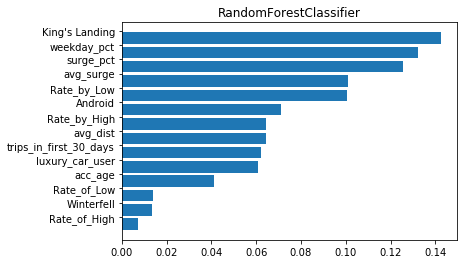

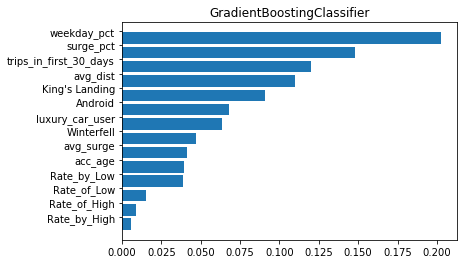

In [83]:
plot_feat_imp(rf)
plt.savefig('RF_feat_imp')
plot_feat_imp(gb)
plt.savefig('GB_feat_imp')

Index([u'avg_dist', u'avg_surge', u'Android', u'surge_pct',
       u'trips_in_first_30_days', u'luxury_car_user', u'weekday_pct',
       u'King's Landing', u'Winterfell', u'acc_age', u'Rate_by_High',
       u'Rate_by_Low', u'Rate_of_High', u'Rate_of_Low'],
      dtype='object')
Index([u'Rate_by_High', u'Rate_of_High', u'Rate_of_Low', u'Rate_by_Low',
       u'acc_age', u'avg_surge', u'Winterfell', u'luxury_car_user', u'Android',
       u'King's Landing', u'avg_dist', u'trips_in_first_30_days', u'surge_pct',
       u'weekday_pct'],
      dtype='object')
[10 12 13 11  9  1  8  5  2  7  0  4  3  6]


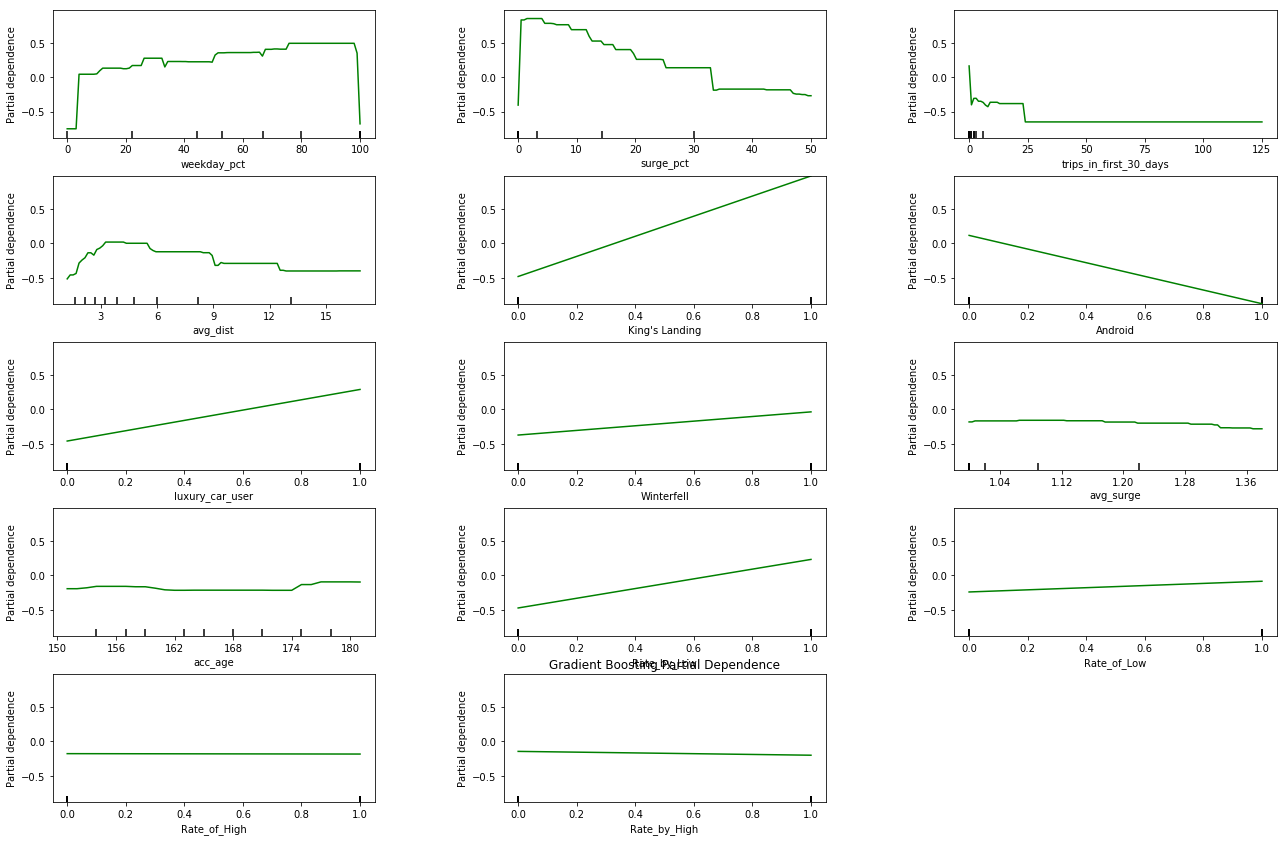

In [84]:
#Partial Dependence
imp = gb.feature_importances_
idx = np.argsort(imp)
print X_train.columns
print X_train.columns[idx]
print idx
plot_partial_dependence(gb,X_train,idx[::-1],
                        feature_names=X_train.columns,
                        figsize=(20,20))
plt.savefig('partial_dependence.jpg')
plt.show()

In [ ]:
#Grid Search
parameters = [{'n_estimators': list(range(25, 201, 25)),
               'max_features': list(range(2, X_train.shape[1], 2)),
                'max_depth': list(range(10,101,10))}]
clf = GridSearchCV(RandomForestClassifier(), parameters, 
                   cv=5, scoring='accuracy', n_jobs=-1)
clf.fit(X_train, y_train)
print clf.best_params_